## Imports

In [89]:
## for data
import pandas as pd
import numpy as np#

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers

## read in data

In [33]:
### list of side effect

side_effects = pd.read_csv('../raw_data/frequent_adr.csv')

#side_effects.head(3)

### read in raw training data

data = pd.read_csv('../raw_data/drugsComTrain_raw.csv')

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [7]:
data.tail()

,uniqueID,drugName,condition,review,rating,date,usefulCount
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,31-May-15,125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,1-Nov-11,34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,15-Mar-14,35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,19-Sep-15,79
161296,215220,Lubiprostone,"Constipation, Chronic","""I&#039;ve had chronic constipation all my adu...",9,13-Dec-14,116


## Preprocessing

In [12]:
### define preprocessing utlities function

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [13]:
### download stopwords

lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [74]:
### creat cleaned text column

data["review_clean"] = data["review"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_clean
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,side effect take combination bystolic 5 mg fis...
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,son halfway fourth week intuniv became concern...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,used take another oral contraceptive 21 pill c...
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,first time using form birth control i039m glad...
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,suboxone completely turned life around feel he...


In [40]:
## make side effects in to a single list of strings

side_effects_lofl = side_effects.values.tolist()
side_effects_lofl
side_effects_list = list(map(''.join, side_effects_lofl)) 
#map(lambda x:x.lower(),side_effects_list)
[x.lower() for x in side_effects_list]
print(side_effects_list)

['Abdominal pain', 'Gastrointestinal pain', 'Amblyopia', 'Anaemia', 'Anorexia', 'Decreased appetite', 'Asthenia', 'Atrial fibrillation', 'Back pain', 'Cardiovascular disorder', 'Chest pain', 'Infection', 'Constipation', 'Cough', 'Depression', 'Diarrhoea', 'Dizziness', 'Dysgeusia', 'Dyspepsia', 'Dyspnoea', 'Eye disorder', 'Body temperature increased', 'Gastrointestinal disorder', 'Headache', 'Haemorrhage', 'Haemoglobin', 'Hypercalcaemia', 'Hyperkalaemia', 'Hypersensitivity', 'Hypertension', 'Hypotension', 'Influenza', 'Cramps of lower extremities', 'Muscle spasms', 'Melaena', 'Nausea', 'Pain', 'Palpitations', 'Parathyroid disorder', 'Paraesthesia', 'Pharyngitis', 'Pruritus', 'Renal failure', 'Rhinitis', 'Tachycardia', 'Urinary tract infection', 'Angiopathy', 'Vertigo', 'Vomiting', 'Weight increased', 'Weight decreased', 'Oedema peripheral', 'Injection site reaction', 'Accidental injury', 'Injury', 'Myalgia', 'Musculoskeletal discomfort', 'Electrocardiogram abnormal', 'Fluid overload', '

### only select reviews with ratings below 6

### create a dictionary with side effects

In [ ]:
## get pretrained word-embedding model
nlp = gensim_api.load("glove-wiki-gigaword-200")

In [90]:
nlp.most_similar(["fatigue"], topn=30)

/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('crepitus', 0.5839619040489197),
 ('diarrheatwice', 0.5786992907524109),
 ('insomniaafter', 0.5593100190162659),
 ('dizziness', 0.558414876461029),
 ('shortn', 0.5558688640594482),
 ('nauseaupset', 0.5542382597923279),
 ('nauseousiness', 0.5423255562782288),
 ('effectssensitivity', 0.5370903611183167),
 ('achene', 0.5335571765899658),
 ('913915', 0.5300567150115967),
 ('nauseaas', 0.5257823467254639),
 ('swingsirratibility', 0.5254141688346863),
 ('asuages', 0.5253233313560486),
 ('shouldersbackneck', 0.5249696969985962),
 ('tiredness', 0.5249460339546204),
 ('fogginesshead', 0.5209469795227051),
 ('neuromusculoskeletal', 0.5151218175888062),
 ('hyperchloremia', 0.5123720765113831),
 ('quotparty', 0.512119472026825),
 ('sleepresulting', 0.5116897821426392),
 ('urinationback', 0.5111106038093567),
 ('slowthinking', 0.5103232860565186),
 ('hangoverlack', 0.5086709856987),
 ('spasmsweakness', 0.5078925490379333),
 ('twitchesspasms', 0.505129873752594),
 ('swellingdiscomfortpain', 0.5048

In [91]:
## Function to apply

def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))

## Create Dictionary {category:[keywords]}
dic_clusters = {}

dic_clusters["SIDE_EFFECTS"] = get_similar_words(['nausea', 'headache', 'fatigue'], 
                  top=50, nlp=nlp)


## print some
for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

SIDE_EFFECTS :  ['582017', 'insomniaafter', 'theeee', 'diarrheatwice', 'shakingthe'] ... 53


/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """


/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


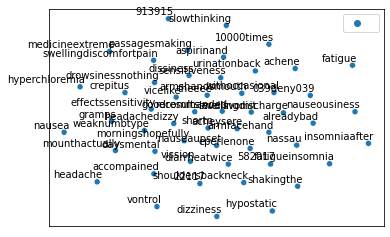

In [92]:
### graph side effecs

## word embedding
tot_words = [word for v in dic_clusters.values() for word in v]
X = nlp[tot_words]

## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(dtf) + len(v)
    dtf_group = pd.DataFrame(X[len(dtf):size], columns=["x","y"], 
                             index=v)
    dtf_group["cluster"] = k
    dtf = dtf.append(dtf_group)

## plot
fig, ax = plt.subplots()
sns.scatterplot(data=dtf, x="x", y="y", hue="cluster", ax=ax)

ax.legend().texts[0].set_text(None)
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], 
       yticks=[], yticklabels=[])

for i in range(len(dtf)):
    ax.annotate(dtf.index[i], 
               xy=(dtf["x"].iloc[i],dtf["y"].iloc[i]), 
               xytext=(5,2), textcoords='offset points', 
               ha='right', va='bottom')

## Feature Engineering

In [94]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [95]:
#### STUCK HERE!!! WHY AM I GETTING THIS IMPORT ERROR!!!

## Word 2 Vec - word embedding

### tranform into list of n-grams

In [75]:
corpus = data["review_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)

trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
                              delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [76]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

Exception ignored in: <function tqdm.__del__ at 0x7ff0284ef710>
Traceback (most recent call last):
  File "/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/tqdm/std.py", line 1150, in __del__
    self.close()
  File "/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm' object has no attribute 'sp'


In [86]:
word = "nausea"
nlp[word].shape

/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(300,)

/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


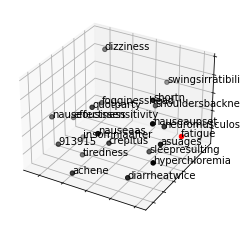

In [87]:
### visual word in x dimensional space

word = "fatigue"
fig = plt.figure()

## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]

## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1

## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

### tokenize and pad text

In [80]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

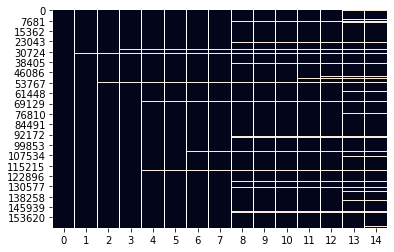

In [81]:
### feature matrix

sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [99]:
i = 0

## list of text: ["I like this", ...]
len_txt = len(data["review_clean"].iloc[i].split())
print("from: ", data["review_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", data["review_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[data["review_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  side effect take combination bystolic 5 mg fish oil | len: 9
to:  [   8    6   12  689 2638   78   71 3471 1314    0    0    0    0    0
    0] | len: 15
check:  side  -- idx in vocabulary --> 8
vocabulary:  {'NaN': 1, 'day': 2, 'month': 3, 'year': 4, 'week': 5} ... (padding element, 0)


### create matrix of embeddings

In [101]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/home/jack/.pyenv/versions/3.7.7/envs/drug_adverse/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [102]:
word = "nausea"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 103 |idx
embeddings[idx]: (300,) |vector


## Build a bidirection LSTM

In [103]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)## apply attention

x = attention_layer(x, neurons=15)## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)

x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)## final dense layers
x = layers.Dense(64, activation='relu')(x)

y_out = layers.Dense(2, activation='softmax')(x)## compile

model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 300)      23547300    input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 15)      0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 300, 15)      240         permute[0][0]                    
_______________________________________________________________________________________

In [105]:
## encode y
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])## train

training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)

NameError: name 'y_train' is not defined